In [59]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from IPython import display
import os
from PIL import Image
from torch.utils.data.dataset import Dataset
from scipy.misc import imread

In [61]:
%matplotlib inline

In [62]:
IMAGE_SIZE = 64
ROOT = '/work/dacb/what_is_a_hotdog'

In [63]:
class NN(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        output = self.fc1(x)
        output = F.relu(output)
        output = self.out(output)
        return output

In [64]:
trans = transforms.Compose([transforms.RandomCrop(64, 64), transforms.Grayscale(1), transforms.ToTensor()])

In [65]:
train_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder(ROOT + '/train', 
                        transform=trans,
                        ),
        batch_size=32, shuffle=True)

In [66]:
test_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder(ROOT + '/test', 
                        transform=trans,
                        ),
        batch_size=8, shuffle=True)

In [36]:
net = NN(IMAGE_SIZE * IMAGE_SIZE, 1024, 10)

In [37]:
import pyro
from pyro.distributions import Normal, Categorical
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [38]:
log_softmax = nn.LogSoftmax(dim=1)

In [39]:
def model(x_data, y_data):
    
    fc1w_prior = Normal(loc=torch.zeros_like(net.fc1.weight), scale=torch.ones_like(net.fc1.weight))
    fc1b_prior = Normal(loc=torch.zeros_like(net.fc1.bias), scale=torch.ones_like(net.fc1.bias))
    
    outw_prior = Normal(loc=torch.zeros_like(net.out.weight), scale=torch.ones_like(net.out.weight))
    outb_prior = Normal(loc=torch.zeros_like(net.out.bias), scale=torch.ones_like(net.out.bias))
    
    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior,  'out.weight': outw_prior, 'out.bias': outb_prior}
    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", net, priors)
    # sample a regressor (which also samples w and b)
    lifted_reg_model = lifted_module()
    
    lhat = log_softmax(lifted_reg_model(x_data))
    
    pyro.sample("obs", Categorical(logits=lhat), obs=y_data)

In [40]:
softplus = torch.nn.Softplus()

def guide(x_data, y_data):
    
    # First layer weight distribution priors
    fc1w_mu = torch.randn_like(net.fc1.weight)
    fc1w_sigma = torch.randn_like(net.fc1.weight)
    fc1w_mu_param = pyro.param("fc1w_mu", fc1w_mu)
    fc1w_sigma_param = softplus(pyro.param("fc1w_sigma", fc1w_sigma))
    fc1w_prior = Normal(loc=fc1w_mu_param, scale=fc1w_sigma_param)
    # First layer bias distribution priors
    fc1b_mu = torch.randn_like(net.fc1.bias)
    fc1b_sigma = torch.randn_like(net.fc1.bias)
    fc1b_mu_param = pyro.param("fc1b_mu", fc1b_mu)
    fc1b_sigma_param = softplus(pyro.param("fc1b_sigma", fc1b_sigma))
    fc1b_prior = Normal(loc=fc1b_mu_param, scale=fc1b_sigma_param)
    # Output layer weight distribution priors
    outw_mu = torch.randn_like(net.out.weight)
    outw_sigma = torch.randn_like(net.out.weight)
    outw_mu_param = pyro.param("outw_mu", outw_mu)
    outw_sigma_param = softplus(pyro.param("outw_sigma", outw_sigma))
    outw_prior = Normal(loc=outw_mu_param, scale=outw_sigma_param).independent(1)
    # Output layer bias distribution priors
    outb_mu = torch.randn_like(net.out.bias)
    outb_sigma = torch.randn_like(net.out.bias)
    outb_mu_param = pyro.param("outb_mu", outb_mu)
    outb_sigma_param = softplus(pyro.param("outb_sigma", outb_sigma))
    outb_prior = Normal(loc=outb_mu_param, scale=outb_sigma_param)
    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior, 'out.weight': outw_prior, 'out.bias': outb_prior}
    
    lifted_module = pyro.random_module("module", net, priors)
    
    return lifted_module()

In [41]:
optim = Adam({"lr": 0.01})
svi = SVI(model, guide, optim, loss=Trace_ELBO())

In [71]:
num_iterations = 50
loss = 0

for j in range(num_iterations):
    loss = 0
    for batch_id, data in enumerate(train_loader):
        # calculate the loss and take a gradient step
        loss += svi.step(data[0].view(-1,IMAGE_SIZE*IMAGE_SIZE), data[1])
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = loss / normalizer_train
    
    print("Epoch ", j, " Loss ", total_epoch_loss_train)

Epoch  0  Loss  19893.569856783677
Epoch  1  Loss  18169.324914167635
Epoch  2  Loss  16588.120469725116
Epoch  3  Loss  15206.080131533156
Epoch  4  Loss  13940.098629731307
Epoch  5  Loss  12765.576792100741
Epoch  6  Loss  11681.058192040122
Epoch  7  Loss  10693.979579005367
Epoch  8  Loss  9808.290670147206
Epoch  9  Loss  9001.58061542535
Epoch  10  Loss  8259.704119338894
Epoch  11  Loss  7608.731888225417
Epoch  12  Loss  6987.765127616365
Epoch  13  Loss  6431.7895142245325
Epoch  14  Loss  5931.080287154376
Epoch  15  Loss  5456.412861542839
Epoch  16  Loss  5059.492350975573
Epoch  17  Loss  4657.11585958689
Epoch  18  Loss  4321.989839046483
Epoch  19  Loss  3984.887795882662
Epoch  20  Loss  3689.988184086502
Epoch  21  Loss  3420.5844165713456
Epoch  22  Loss  3205.050836259179
Epoch  23  Loss  3002.884604592844
Epoch  24  Loss  2832.699727568154
Epoch  25  Loss  2624.4453423726213
Epoch  26  Loss  2475.139631533413
Epoch  27  Loss  2321.470696641929
Epoch  28  Loss  2176

In [73]:
num_samples = 10
def predict(x):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [model(x).data for model in sampled_models]
    mean = torch.mean(torch.stack(yhats), 0)
    return np.argmax(mean.numpy(), axis=1)

print('Prediction when network is forced to predict')
correct = 0
total = 0
for j, data in enumerate(test_loader):
    images, labels = data
    predicted = predict(images.view(-1,IMAGE_SIZE*IMAGE_SIZE))
    total += labels.size(0)
    correct += (torch.tensor(predicted) == labels).sum().item()
print("accuracy: %d %%" % (100 * correct / total))

Prediction when network is forced to predict
accuracy: 64 %


In [125]:
idx_to_class = dict([(value, key) for key, value in train_loader.dataset.class_to_idx.items()]) 

In [126]:
hotdog_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder(ROOT + '/hotdog', 
                        transform=trans,
                        ),
        batch_size=8, shuffle=True)

In [127]:
num_samples = 10
def predict(x):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [model(x).data for model in sampled_models]
    mean = torch.mean(torch.stack(yhats), 0)
    return np.argmax(mean.numpy(), axis=1)

predictions = {}
for cls in idx_to_class.values():
    predictions[cls] = 0
    
for j, data in enumerate(hotdog_loader):
    images, labels = data
    predicted = predict(images.view(-1,IMAGE_SIZE*IMAGE_SIZE))
    for pred in predicted:
        predictions[idx_to_class[pred]] = predictions[idx_to_class[pred]] + 1

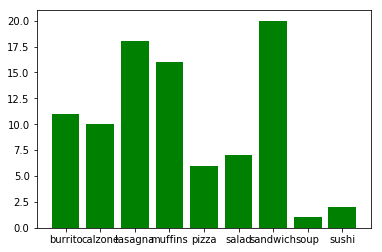

In [130]:
plt.bar(list(predictions.keys()), predictions.values(), color='g')
plt.show()

In [129]:
predictions

{'burrito': 11,
 'calzone': 10,
 'lasagna': 18,
 'muffins': 16,
 'pizza': 6,
 'salad': 7,
 'sandwich': 20,
 'soup': 1,
 'sushi': 2}